In [1]:
import json
import urllib
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.metrics import mean_absolute_percentage_error as MAPE

warnings.filterwarnings('ignore')

In [2]:
PC = '#FF3B2B'
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
months = ['January','February','March','April','May','June','July','August','September','October','November','December']

In [3]:
def retrieve_data(DS,DE):

  """Extract data using wikimedia api"""

  with urllib.request.urlopen(f'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/en.wikipedia/all-access/all-agents/daily/{DS}/{DE}') as url:
    data = json.loads(url.read().decode())

  data = pd.DataFrame(data['items'])[['timestamp','views']]
  data.timestamp = data.timestamp.apply(lambda x:x[0:-2])
  data.timestamp = pd.DatetimeIndex(data.timestamp)
  data.set_index('timestamp',inplace=True)
  data.index.name = None

  data['views'] = data['views']/1e6

  return data

In [4]:
data = retrieve_data('2018010100','2022033100')

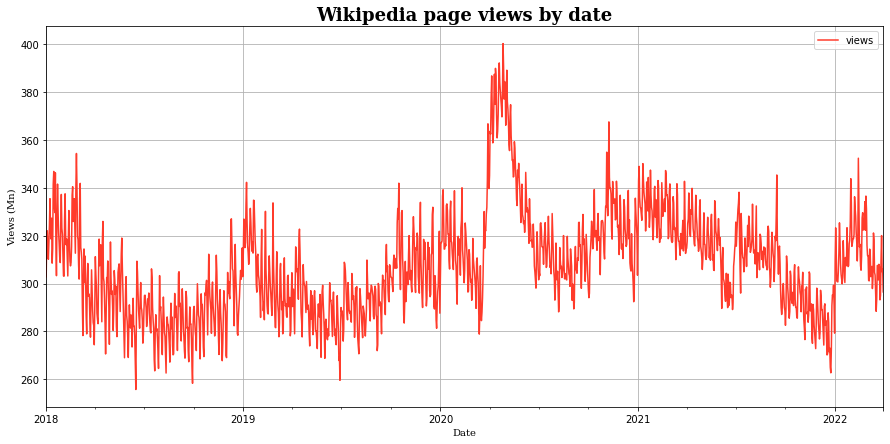

In [5]:
ax = data.plot(figsize=(15,7),color=PC,alpha=1.0)
plt.xlabel("Date",fontfamily='serif')
plt.ylabel("Views (Mn)",fontfamily='serif')
plt.title("Wikipedia page views by date", fontsize=18,fontweight='semibold',fontfamily='serif')
plt.grid(True)
plt.show()

In [6]:
data.index.freq = 'D'

In [7]:
data =data.assign(
    day_name=lambda x:x.index.day_name(),
    month_name=lambda x:x.index.month_name()
    )

In [8]:
data.head()

,views,day_name,month_name
2018-01-01,302.828330,Monday,January
2018-01-02,319.485738,Tuesday,January
2018-01-03,322.019675,Wednesday,January
2018-01-04,314.645741,Thursday,January
2018-01-05,310.155899,Friday,January


## Get get features by day and month

In [9]:
dayname_features = data.groupby(
                        "day_name").agg(
                                {"views":['sum','mean','max','min']}
                                ).reset_index()
dayname_features.columns.name = None
dayname_features.columns =['day_name','views_sum','views_mean','views_max','views_min']
dayname_features['day_name'] = pd.Categorical(dayname_features['day_name'], categories=days, ordered=True)
dayname_features.sort_values('day_name',inplace=True)

In [10]:
dayname_features

,day_name,views_sum,views_mean,views_max,views_min
1,Monday,70434.542736,317.272715,390.498991,283.736768
5,Tuesday,68740.294825,309.640968,380.040469,271.438349
6,Wednesday,68261.335449,307.483493,384.315863,273.133636
4,Thursday,67610.818239,304.553235,382.262497,265.038764
0,Friday,66073.242168,298.973946,387.365535,262.739827
2,Saturday,66145.746725,299.302021,384.117144,255.779378
3,Sunday,69700.115576,315.385138,400.173009,280.716105


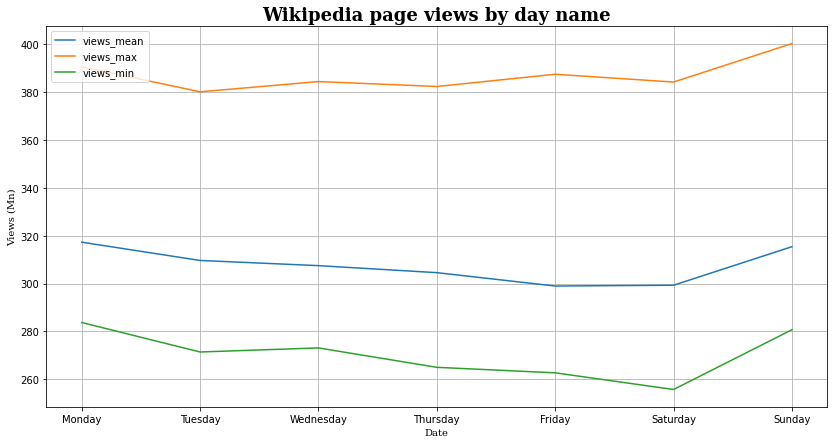

In [11]:
ax = dayname_features.set_index('day_name').drop(['views_sum'],axis=1).plot(figsize=(14,7))

plt.legend(loc='upper left')
plt.xlabel("Date",fontfamily='serif')
plt.ylabel("Views (Mn)",fontfamily='serif')
plt.title("Wikipedia page views by day name", fontsize=18,fontweight='semibold',fontfamily='serif')
plt.grid(True)
plt.show()

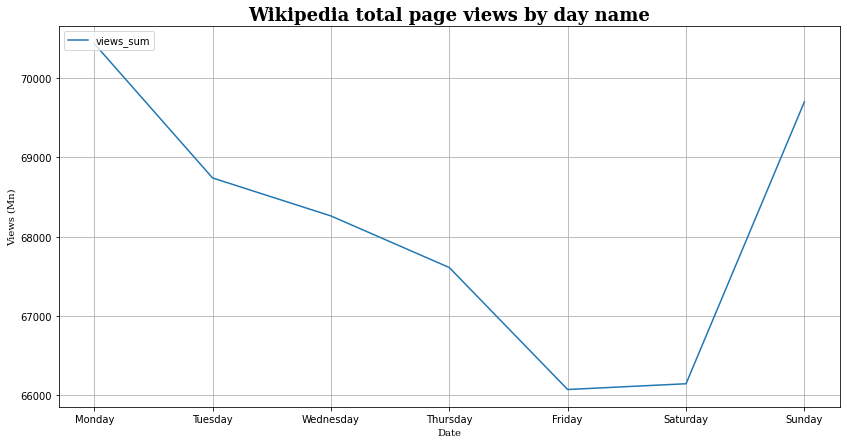

In [12]:
ax = dayname_features.set_index('day_name')['views_sum'].plot(figsize=(14,7))

plt.legend(loc='upper left')
plt.xlabel("Date",fontfamily='serif')
plt.ylabel("Views (Mn)",fontfamily='serif')
plt.title("Wikipedia total page views by day name", fontsize=18,fontweight='semibold',fontfamily='serif')
plt.grid(True)
plt.show()

In [13]:
monthname_features = data.groupby(
                        "month_name").agg(
                                {"views":['sum','mean','max','min']}
                                ).reset_index()
monthname_features.columns.name = None
monthname_features.columns =['month_name','views_sum','views_mean','views_max','views_min']
monthname_features['month_name'] = pd.Categorical(monthname_features['month_name'], categories=months, ordered=True)
monthname_features.sort_values('month_name',inplace=True)

In [14]:
monthname_features

,month_name,views_sum,views_mean,views_max,views_min
4,January,49766.831681,321.076333,350.059568,296.418351
3,February,44753.023918,317.397333,354.301601,284.884431
7,March,47450.584068,306.132800,366.672604,274.449811
0,April,38906.709648,324.222580,400.173009,270.620673
8,May,38826.039323,313.113220,389.058822,269.032410
6,June,35694.489972,297.454083,346.411414,255.779378
5,July,37476.303233,302.228252,338.117210,263.558899
1,August,36886.605889,297.472628,333.144561,262.649310
11,September,35840.209353,298.668411,345.324904,258.355412
10,October,37522.878319,302.603857,341.898107,268.539580


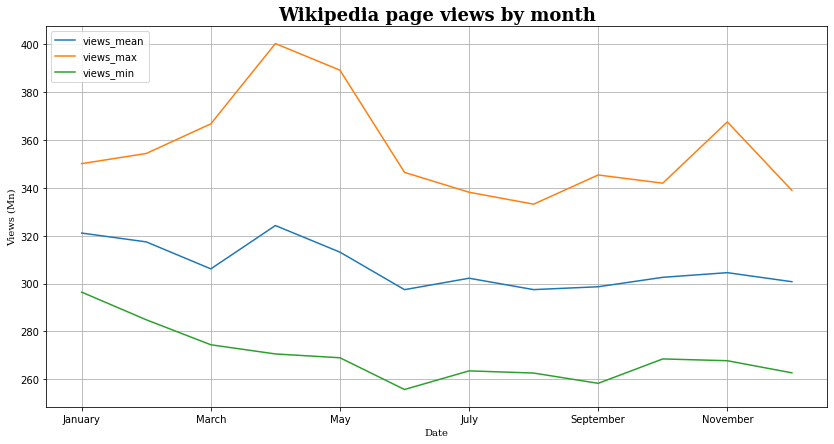

In [15]:
ax = monthname_features.set_index('month_name').drop(['views_sum'],axis=1).plot(figsize=(14,7))

plt.legend(loc='upper left')
plt.xlabel("Date",fontfamily='serif')
plt.ylabel("Views (Mn)",fontfamily='serif')
plt.title("Wikipedia page views by month", fontsize=18,fontweight='semibold',fontfamily='serif')
plt.grid(True)
plt.show()

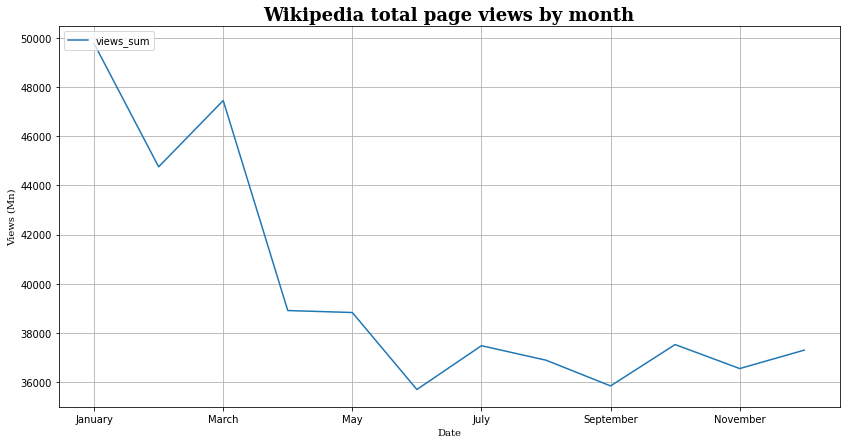

In [16]:
ax = monthname_features.set_index('month_name')['views_sum'].plot(figsize=(14,7))

plt.legend(loc='upper left')
plt.xlabel("Date",fontfamily='serif')
plt.ylabel("Views (Mn)",fontfamily='serif')
plt.title("Wikipedia total page views by month", fontsize=18,fontweight='semibold',fontfamily='serif')
plt.grid(True)
plt.show()

## Modeling

#### First of all let's plot **P**artial **A**uto **C**orrelation **F**unction for dataset

Partial autocorrelation is a measures of association between current and past series values and indicate which past series values are most useful in predicting future values. We'll discus more about this in upcomming notebook related to ARIMA models.

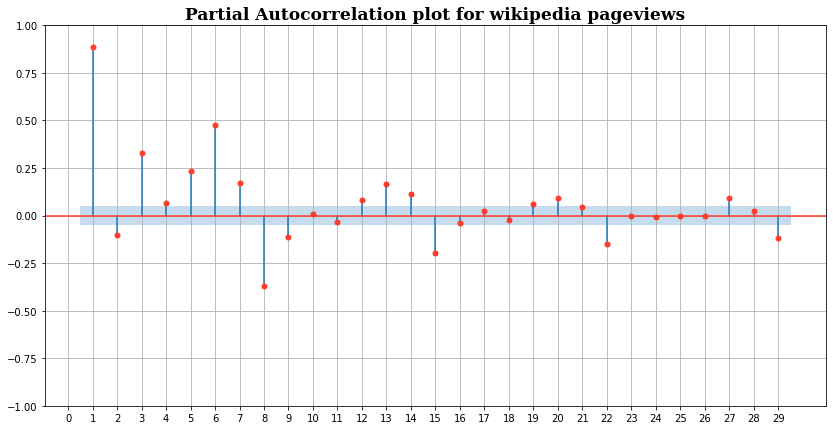

In [17]:
_,ax = plt.subplots(1,1,figsize=(14,7))
plot_pacf(data.views,ax=ax,lags=range(1,30),method='ywm',color=PC)
plt.title("Partial Autocorrelation plot for wikipedia pageviews",fontsize=17,fontfamily='serif',fontweight='semibold')
plt.xticks(range(0,30))
plt.grid(True)
plt.show()

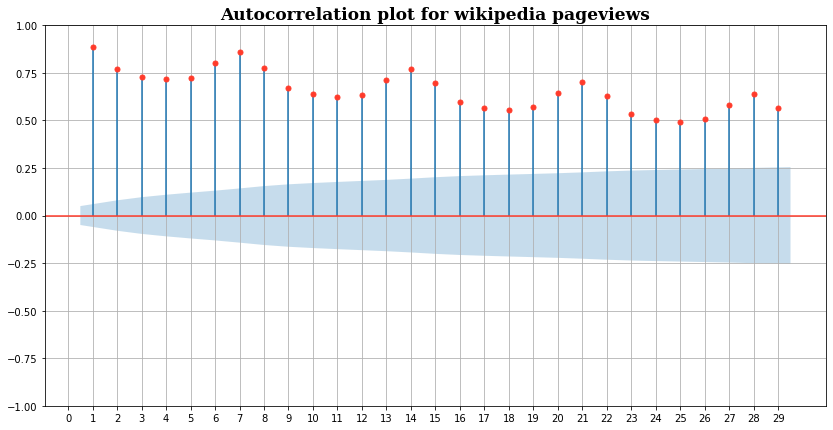

In [18]:
_,ax = plt.subplots(1,1,figsize=(14,7))
plot_acf(data.views,ax=ax,lags=range(1,30),color=PC)
plt.title("Autocorrelation plot for wikipedia pageviews",fontsize=17,fontfamily='serif',fontweight='semibold')
plt.xticks(range(0,30))
plt.grid(True)
plt.show()

As we can see above plots, the past day page view is highly corelated with today's page views. The correlation of today's page views and 7 days ago page views also very high.

Let's build a baseline model, that predict above mentioned pattern.

In [19]:
def baseline(train,future:int=21):
    preds = pd.DataFrame(index=pd.date_range(start=max(train.index),periods=future+1,inclusive='right'))
    preds['views'] = np.nan
    preds['views'] = pd.concat([train,preds]).views.shift(future)
    return preds

In [20]:
def plot_predictions(observed,predicted):

    error = "{0:.3f}%".format(MAPE(observed,predicted)*100)

    plt.figure(figsize=(15,7))
    plt.plot(observed,color='black',label='oberved')
    plt.plot(predicted,color=PC,label='predicted')
    plt.legend(loc='upper center')
    plt.xlabel("Date",fontfamily='serif')
    plt.ylabel("Views (Mn)",fontfamily='serif')
    plt.title(f"Predictions vs Observed\nMAPE={error}", fontsize=18,fontweight='semibold',fontfamily='serif')
    plt.grid(True)
    plt.show()

In [21]:
train = data.iloc[0:1530][['views']]
test = data.iloc[1530:][['views']]

In [22]:
preds = baseline(train)

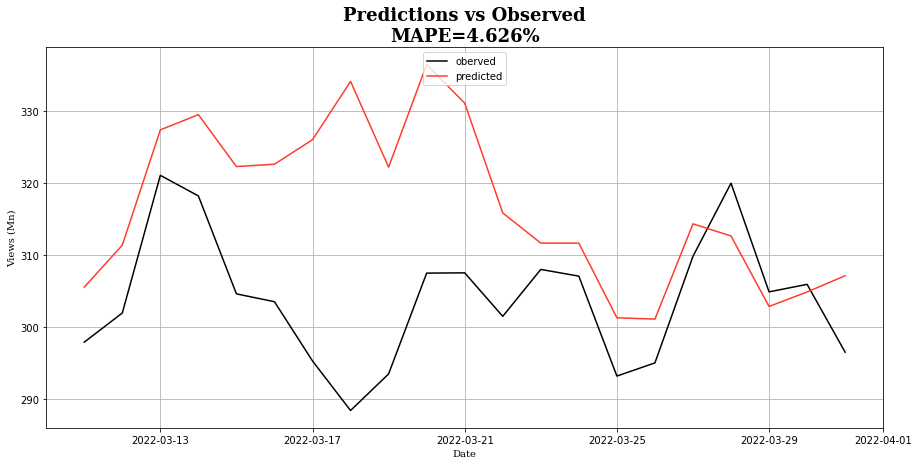

In [23]:
plot_predictions(test,preds)

## Lets build XGB model that can beat our baseling model

In [24]:
data.loc[:,'is_weekend'] = data.pipe(
    lambda x:pd.Series(x.day_name.isin(['Saturday','Sunday']),dtype='int')
)

In [25]:
data = pd.get_dummies(data)

In [26]:
train = data.iloc[0:1530]
test = data.iloc[1530:]

In [27]:
y = train.pop('views')
X = train

In [28]:
bst = XGBRegressor()
bst.fit(X,y)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [29]:
oberved = test['views']
test = test.drop(['views'],axis=1)

In [30]:
predictions = pd.DataFrame(index=oberved.index)
predictions['views'] = bst.predict(test)

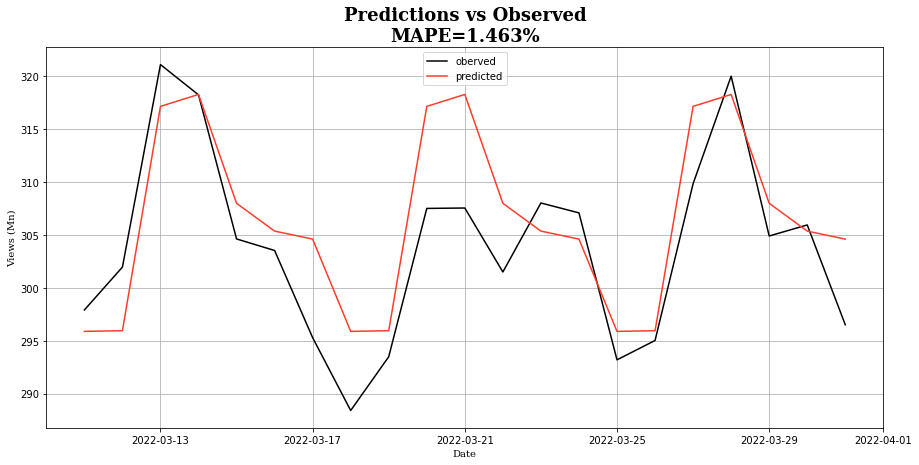

In [31]:
plot_predictions(oberved,predictions)